In [288]:
# magics: ensures that any changes to the modules loaded below will be re-loaded automatically
%load_ext autoreload
%autoreload 2

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import copy
import scipy.optimize as optimize

from mytest import child_model
import NPL
from Solve_NFXP import solve_NFXP
import estimate_NFXP as estimate



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [281]:
model = child_model()





In [282]:
solver = solve_NFXP()
ev,pk = solver.poly(model.bellman, beta = model.beta, output=2)

# data
data = model.sim_data(pk)
samplesize = data.shape[0]
print(pk, ev)
data

[0.2890505 0.2890505 0.2890505 0.2890505 0.2890505] [-13578.95699135 -13582.58433812 -13585.77574586 -13587.9255615
 -13588.4612527 ]


,id,t,d,x,dx1,x1
0,1,1,0.0,0,0,0
1,1,2,1.0,0,0,0
2,1,3,1.0,0,0,0
3,1,4,1.0,0,0,0
4,1,5,1.0,0,0,0
...,...,...,...,...,...,...
9995,1000,6,0.0,2,1,3
9996,1000,7,1.0,3,0,3
9997,1000,8,0.0,3,1,4
9998,1000,9,0.0,4,1,4


In [259]:
tabulate = data.dx1.value_counts()
p = [tabulate[i]/sum(tabulate) for i in range(tabulate.size-1)]
tabulate

0    8022
1    1978
Name: dx1, dtype: int64

In [249]:
print('Model grid:\n',model.grid)
print('Transition probabilities conditional on not replacing:\n',model.P1)
print('Transition probabilities conditional on replacing:\n',model.P2)
ev,pk, dev = model.bellman(np.zeros((model.n)),output=3)
print('Bellman one run:\n',ev)
print('Bellman pk:\n',pk)

Model grid:
 [0 1 2 3 4]
Transition probabilities conditional on not replacing:
 [[0.3 0.7 0.  0.  0. ]
 [0.  0.3 0.7 0.  0. ]
 [0.  0.  0.3 0.7 0. ]
 [0.  0.  0.  0.3 0.7]
 [0.  0.  0.  0.  1. ]]
Transition probabilities conditional on replacing:
 [[9.9999e-01 1.0000e-05 0.0000e+00 0.0000e+00 0.0000e+00]
 [0.0000e+00 9.9999e-01 1.0000e-05 0.0000e+00 0.0000e+00]
 [0.0000e+00 0.0000e+00 9.9999e-01 1.0000e-05 0.0000e+00]
 [0.0000e+00 0.0000e+00 0.0000e+00 9.9999e-01 1.0000e-05]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00]]
Bellman one run:
 [ 1.20615387  0.87615387  0.14615387 -0.98384613 -1.35884613]
Bellman pk:
 [0.2890505 0.2890505 0.2890505 0.2890505 0.2890505]


In [260]:
# Find tha likelihood value for different combinations 

par_mu = copy.copy(model.mu)
par_eta2 = copy.copy(model.eta2)

NRC = 50
Nc = 50

log_lik = np.nan + np.zeros((NRC,Nc))
mu= np.linspace(-1,1,NRC)
eta2 = np.linspace(-1,1,Nc)

for i in range(NRC):
    for j in range(Nc):
       
        # STEP 1: Find p 
        tabulate = data.dx1.value_counts()
        p = [tabulate[i]/sum(tabulate) for i in range(tabulate.size-1)]

        # STEP 2: Estimate structual parameters
        model.p = p # Use first step estimates as starting values for t
    
        # Estimate RC and C
        pnames = ['mu','eta2']
        theta = np.array([mu[i], eta2[j]])
        log_lik[i,j]=estimate.ll(theta,model, solver,data, pnames)

log_lik *= samplesize*(-1)

#Re-inset the true parameters 
model.mu = copy.copy(par_mu)
model.eta2 = copy.copy(par_eta2)

print(model.mu, model.eta2)

0.9 0.15


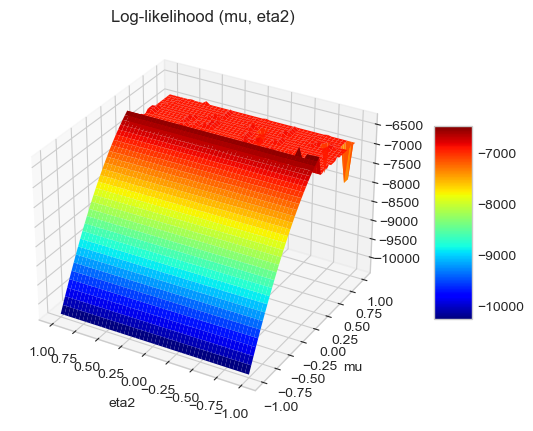

In [261]:
# plot figure in three dimensions
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
plt.style.use('seaborn-whitegrid')


fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,1,1,projection='3d')

# Make data.
X, Y = np.meshgrid(eta2, mu)

# Plot the surface.
surf = ax.plot_surface(X, Y, log_lik, cmap=cm.jet)

# Customize the axis.
ax.set_xlabel(f'eta2')
ax.set_ylabel(f'mu')
ax.set_title(f'Log-likelihood (mu, eta2)')
ax.invert_xaxis()

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

In [299]:

model = child_model()
theta0 = [0,0,0] + model.p.tolist()

# Estimate
nfxp_model, nfxp_results, pnames, theta_hat, Avar, converged = estimate.estimate(model, solver, data, theta0=theta0)

# Print 
print(f'Log-Likelihood:     {-nfxp_results.fun*samplesize:.4f}')
print(f'mu:                 {theta_hat[0]:.4f}')
print(f'eta2:               {theta_hat[1]:.4f}')
print(f'eta3:               {theta_hat[2]:.4f}')


LinAlgError: Singular matrix

In [290]:
res = optimize.minimize(ll,theta0, args = (model,solver,data, pnames), method = 'trust-ncg',jac = grad, hess = hes, tol = 1e-8)


NameError: name 'll' is not defined

In [300]:
res = optimize.minimize(estimate.ll,theta0, args = (model,solver,data,['mu','eta2', 'eta3']), method = 'trust-ncg',jac = estimate.grad, hess = estimate.hes, tol = 1e-8)

res.x


array([0. , 0. , 0. , 0.3, 0.7])